In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


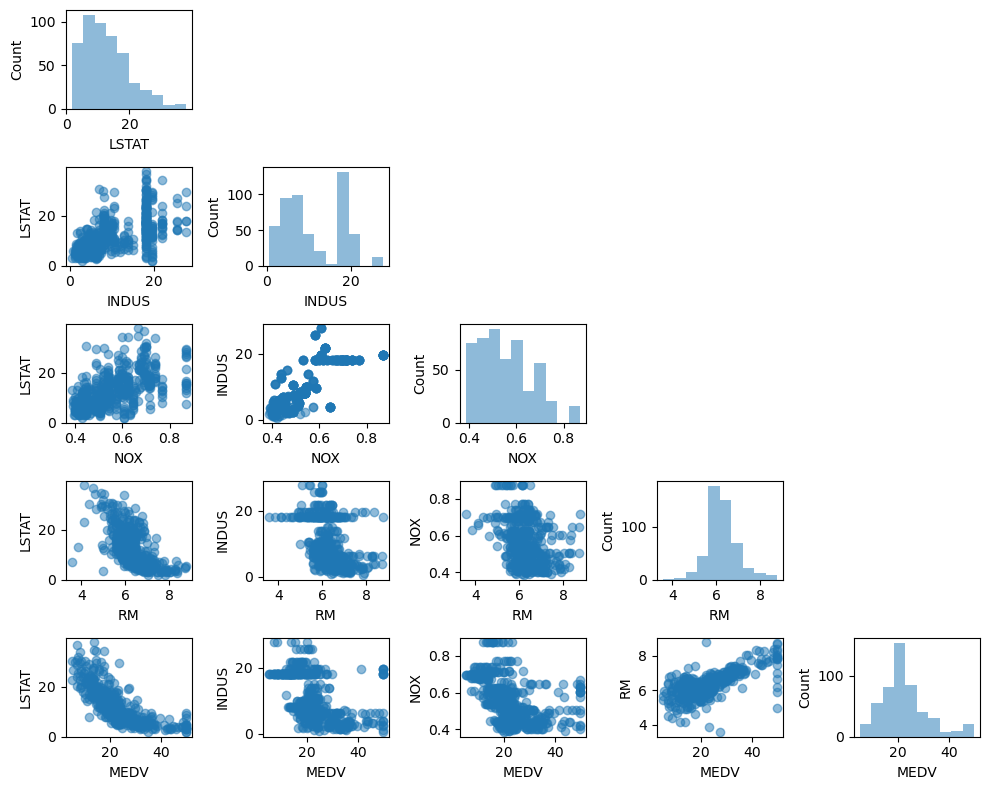

In [2]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

scatterplotmatrix(df[cols].values, figsize=(10, 8),
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

<AxesSubplot:>

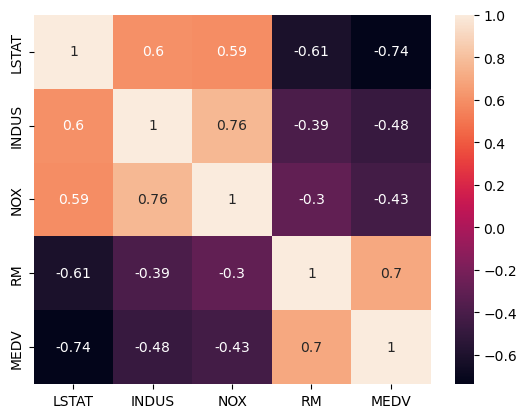

In [3]:
import seaborn as sns
corrmat = df[['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] ].corr(method='pearson')
sns.heatmap(corrmat, annot=True)

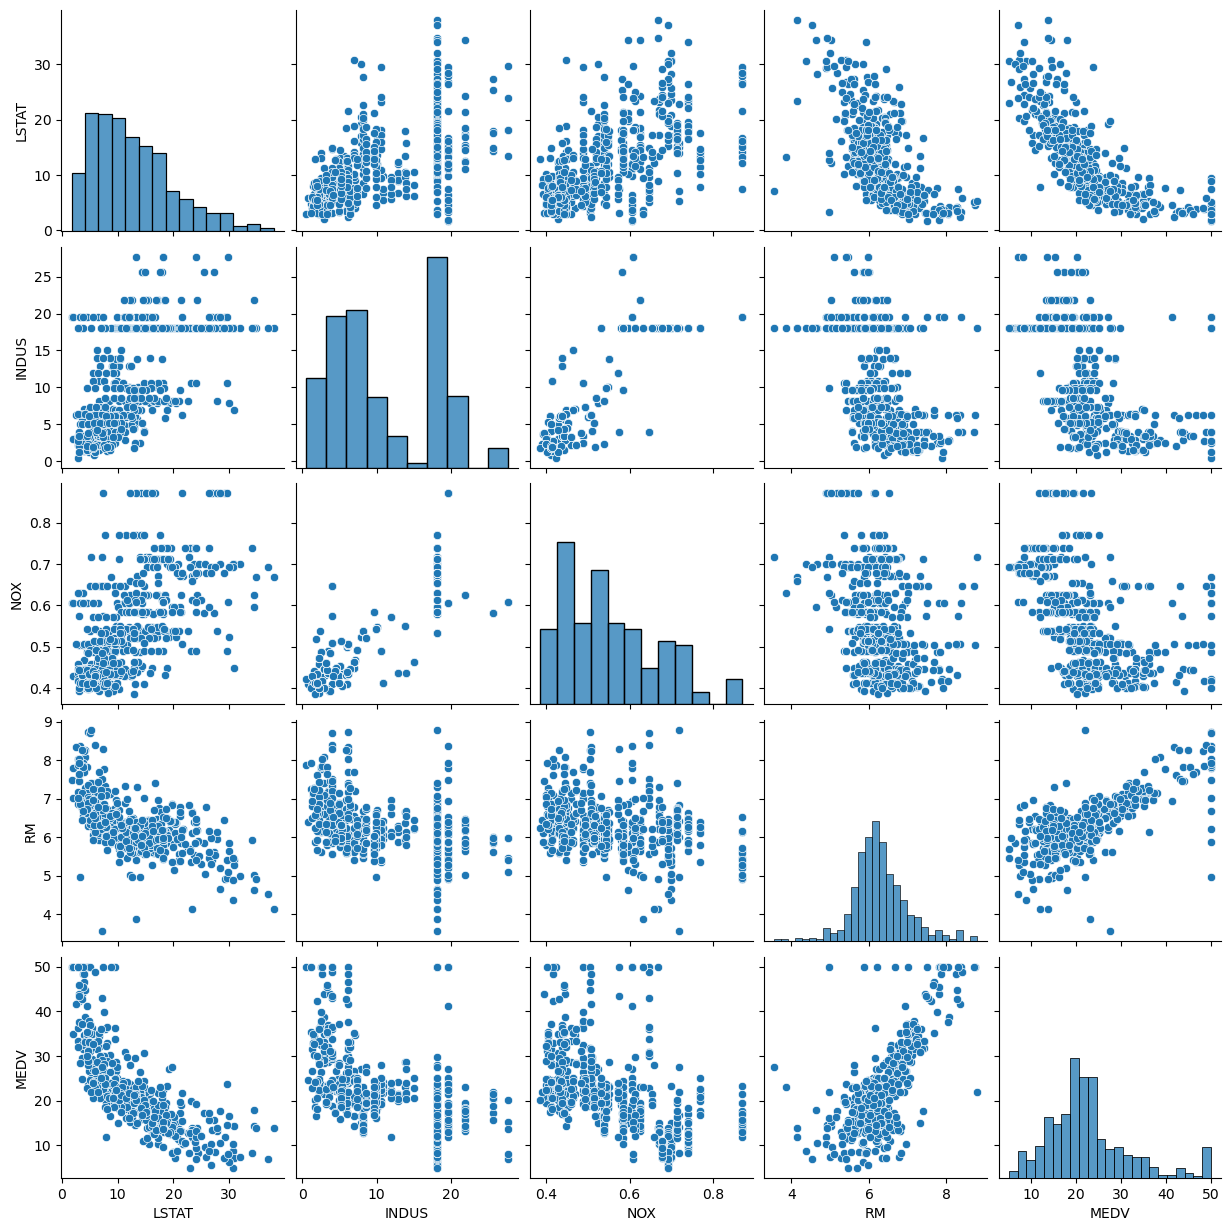

In [8]:
house = df[ ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] ]
sns.pairplot(house)
plt.show()

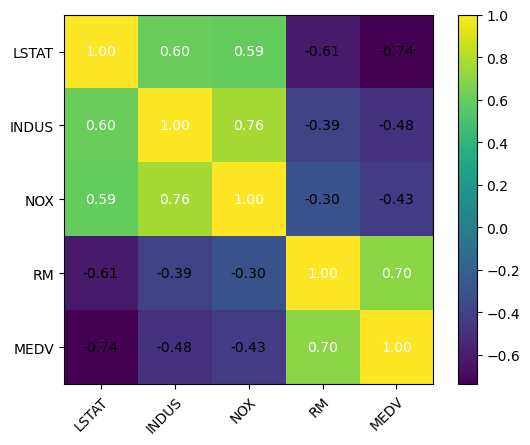

In [9]:
import numpy as np
from mlxtend.plotting import heatmap


cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

# plt.savefig('images/10_04.png', dpi=300)
plt.show()

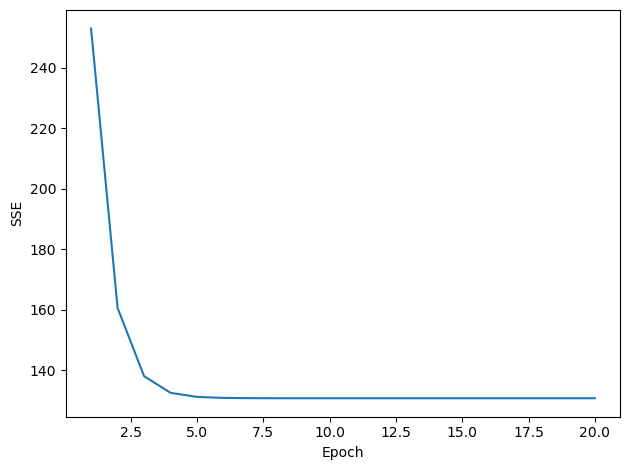

In [11]:
#경사하강법으로 회귀 모델의 파라미터 구하기
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)
    
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('images/10_05.png', dpi=300)
plt.show()

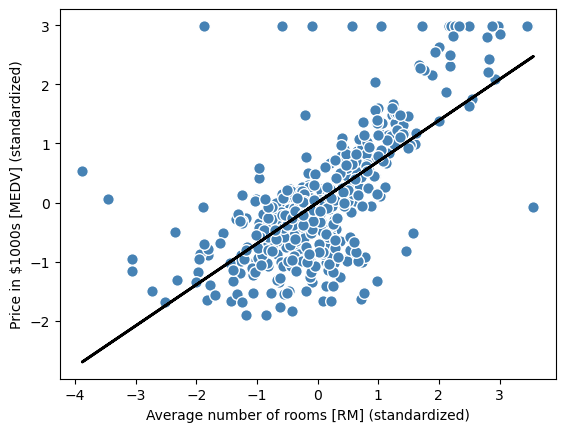

In [12]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

plt.show()

In [13]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("$1,000 단위 가격: %.3f" % sc_y.inverse_transform(price_std.reshape(-1,1))) #inverse_transform : 표준화 거꾸로 되돌리기

$1,000 단위 가격: 10.840


기울기: 9.102
절편: -34.671


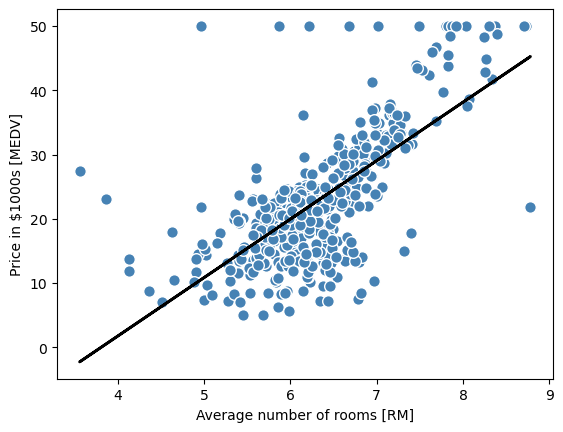

In [14]:
#사이킷런
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

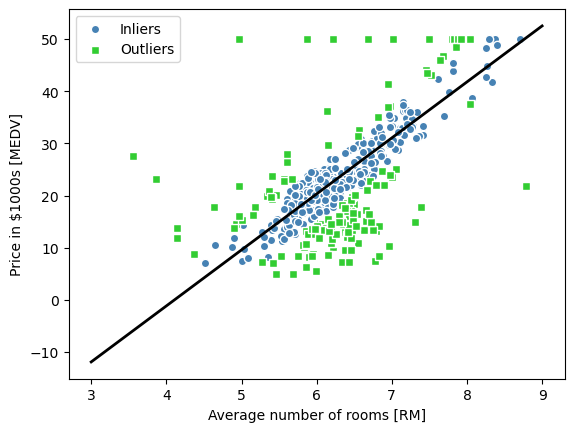

In [16]:
#RANSAC
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_error',
                         residual_threshold=5.0,
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

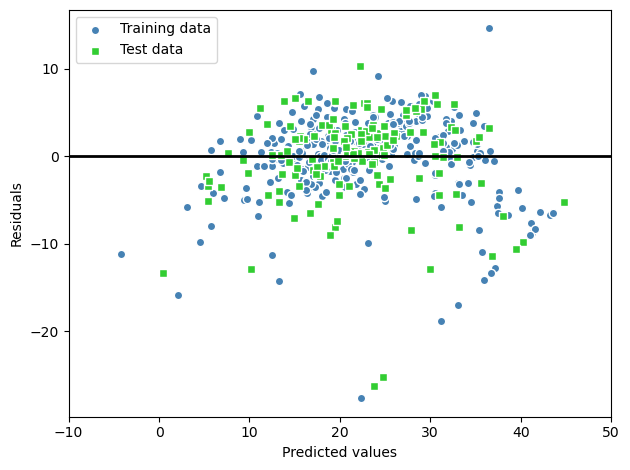

In [17]:
#성능평가1. 잔차그래프
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

In [18]:
#성능평가1. MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 19.958, 테스트 MSE: 27.196
훈련 R^2: 0.765, 테스트 R^2: 0.673
